# CP 05 - Front End
Recomendação de filmes (**Clusterização**)

## Importação de bibliotecas e do dataset

In [23]:
import pandas as pd
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
from joblib import dump
import warnings

# Baixar stopwords em português da NLTK (caso não tenha baixado ainda)
nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Carregar o dataset
file_path = '/content/all_movies.csv'  # Substituir pelo caminho correto
df = pd.read_csv(file_path, delimiter=';')

## Análise exploratória (EDA)

In [52]:
# Visualizar as primeiras linhas do dataset
df.head()

,title_pt,title_en,year,rating,genre,sinopse
0,Barbie,Barbie,2023,7.4,Aventura,Viver na Terra da Barbie é ser um ser perfeito...
1,Um Sonho de Liberdade,1. The Shawshank Redemption,1994,9.3,Drama,Dois homens presos se reúnem ao longo de vário...
2,O Poderoso Chefão,2. The Godfather,1972,9.2,Policial,O patriarca idoso de uma dinastia do crime org...
3,Batman: O Cavaleiro das Trevas,3. The Dark Knight,2008,9.0,Ação,Quando a ameaça conhecida como O Coringa surge...
4,O Poderoso Chefão II,4. The Godfather Part II,1974,9.0,Policial,"Em 1950, Michael Corleone, agora à frente da f..."


In [53]:
# Estatísticas descritivas
df.describe()

,year,rating
count,250.000000,250.000000
mean,1986.684000,8.302800
std,25.508171,0.239545
min,1921.000000,7.400000
25%,1966.000000,8.100000
50%,1994.000000,8.200000
75%,2007.000000,8.400000
max,2023.000000,9.300000


### Distribuição de Ratings

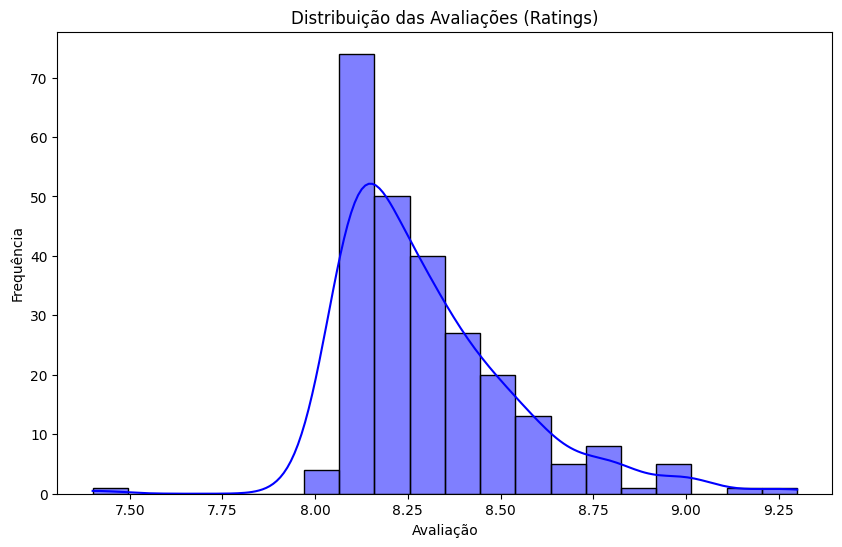

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True, bins=20, color='blue')
plt.title('Distribuição das Avaliações (Ratings)')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.show()

### Distribuição do Ano de Lançamento

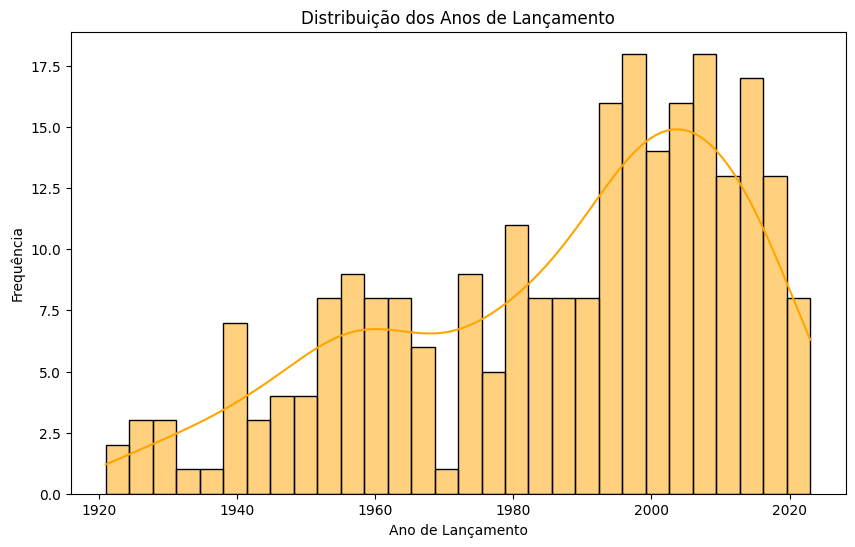

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df['year'], kde=True, bins=30, color='orange')
plt.title('Distribuição dos Anos de Lançamento')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Frequência')
plt.show()

### Qtd Filmes por Gênero

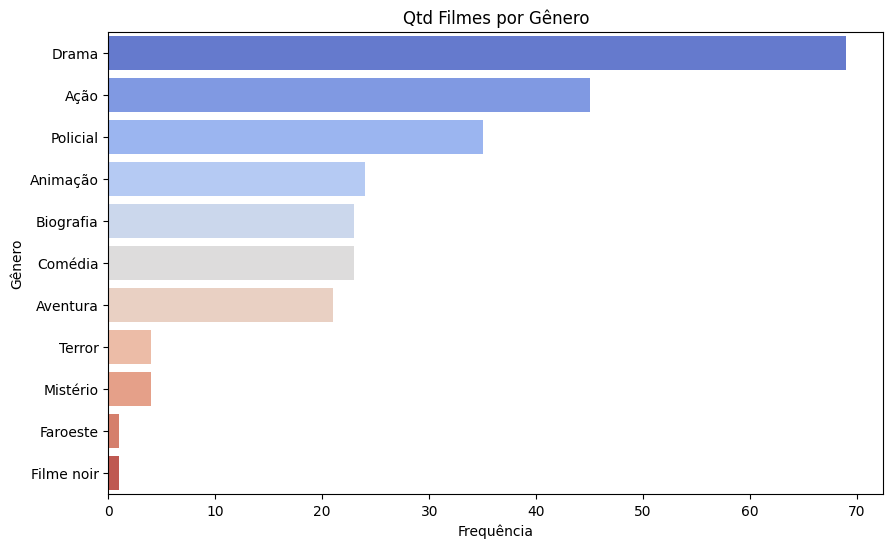

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index, palette='coolwarm')
plt.title('Qtd Filmes por Gênero')
plt.xlabel('Frequência')
plt.ylabel('Gênero')
plt.show()

### Qtd filmes por ano

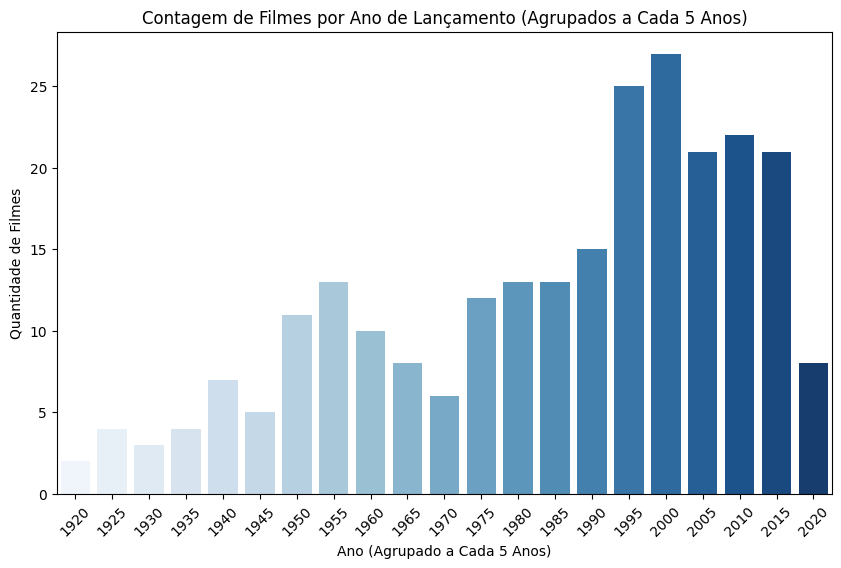

In [57]:
# Criar uma nova coluna 'year_grouped' que agrupa os anos a cada 5 anos
df['year_grouped'] = (df['year'] // 5) * 5

plt.figure(figsize=(10, 6))
sns.countplot(x='year_grouped', data=df, palette='Blues')
plt.title('Contagem de Filmes por Ano de Lançamento (Agrupados a Cada 5 Anos)')
plt.xlabel('Ano (Agrupado a Cada 5 Anos)')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=45)
plt.show()

### Gráfico de Gênero e Avaliação

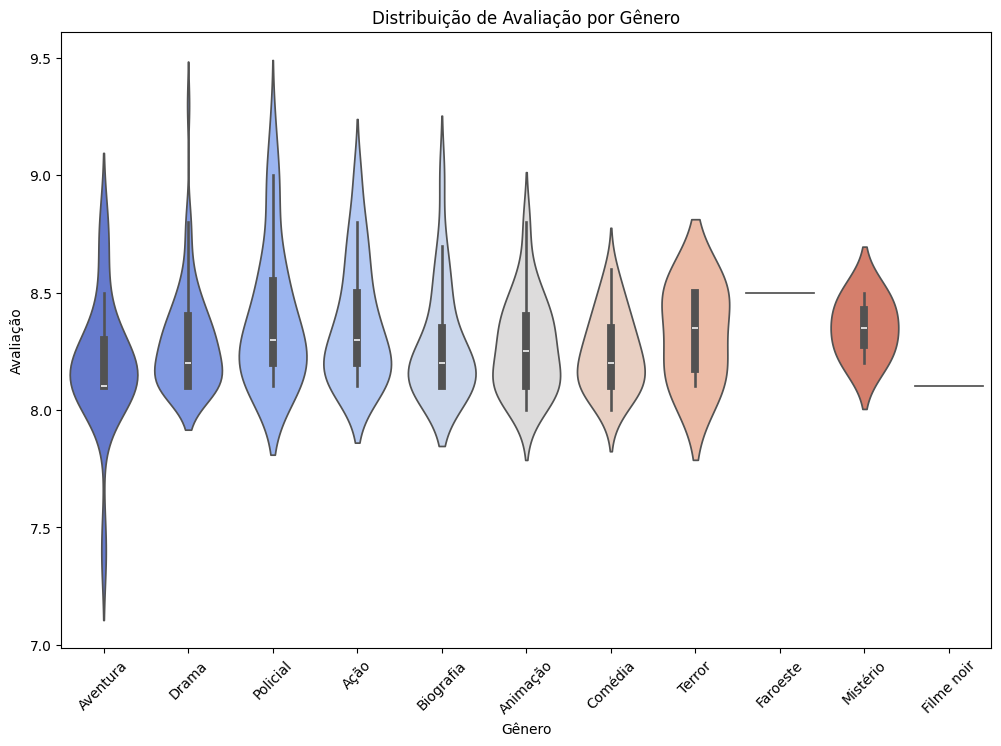

In [58]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='genre', y='rating', data=df, palette='coolwarm')
plt.title('Distribuição de Avaliação por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Avaliação')
plt.xticks(rotation=45)
plt.show()

### Relação entre Gênero e Ano de Lançamento

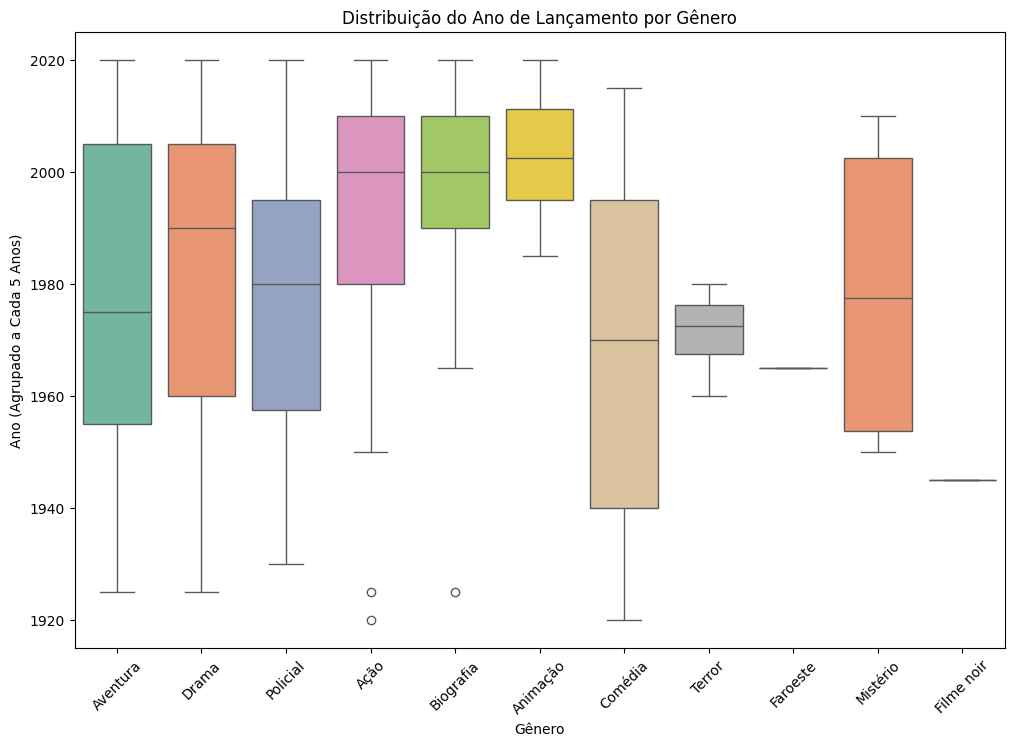

In [59]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='year_grouped', data=df, palette='Set2')
plt.title('Distribuição do Ano de Lançamento por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Ano (Agrupado a Cada 5 Anos)')
plt.xticks(rotation=45)
plt.show()

### Heatmap para correlação entre as variáveis numéricas

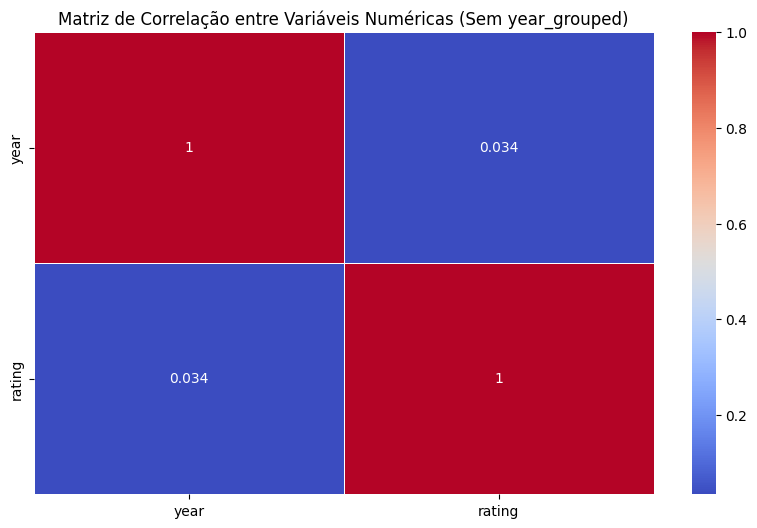

In [60]:
plt.figure(figsize=(10, 6))

# Selecionar apenas as colunas numéricas, excluindo 'year_grouped'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns=['year_grouped'])

# Gerar o heatmap com as colunas numéricas restantes
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas (Sem year_grouped)')
plt.show()

## Tratamento dos dados

In [61]:
df = df.drop(columns=['year_grouped'])

### Normalização

In [62]:
scaler = StandardScaler()
df[['rating', 'year']] = scaler.fit_transform(df[['rating', 'year']])

### Embeddings

In [63]:
def get_bert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.detach().numpy()

In [64]:
# Carregar o modelo BERT e o tokenizer para bert-base-multilingual-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertModel.from_pretrained('bert-base-multilingual-uncased')

# Gerar embeddings para todas as sinopses
bert_embeddings = np.vstack([get_bert_embedding(sinopse, model, tokenizer) for sinopse in df['sinopse']])

## Modelo de clusterização

### Escolha da quantidade de cluster (Metodo do cotovelo)

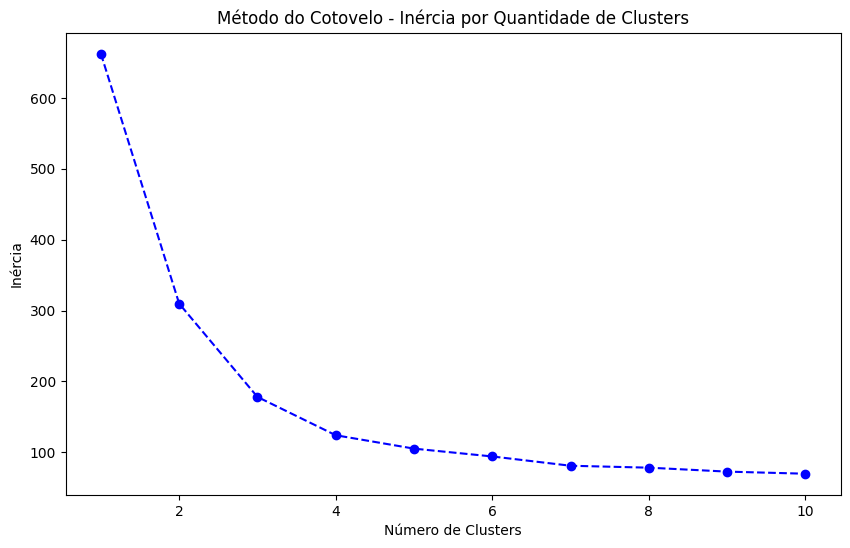

In [67]:
def plot_elbow_method(embeddings, max_clusters=10):
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), sse, marker='o', linestyle='--', color='b')
    plt.title('Método do Cotovelo - Inércia por Quantidade de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.show()

plot_elbow_method(bert_embeddings)

### Modelo

In [68]:
# Escolher 5 clusters com base no gráfico do cotovelo
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(bert_embeddings)

## Avaliação do modelo

### Score

In [70]:
silhouette_avg = silhouette_score(bert_embeddings, df['cluster'])
db_index = davies_bouldin_score(bert_embeddings, df['cluster'])

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_index}')

Silhouette Score: 0.2895413339138031
Davies-Bouldin Index: 0.9807725822961892


### Gráfico de Sombra/Silhueta

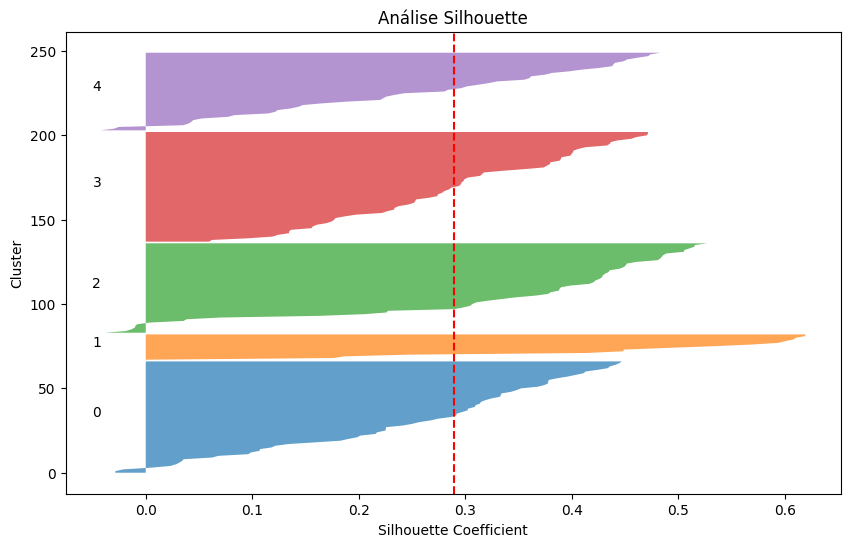

In [72]:
def plot_silhouette_analysis(embeddings, cluster_labels):
    silhouette_vals = silhouette_samples(embeddings, cluster_labels)
    y_lower, y_upper = 0, 0
    n_clusters = len(np.unique(cluster_labels))
    plt.figure(figsize=(10, 6))

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.title('Análise Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.show()

plot_silhouette_analysis(bert_embeddings, df['cluster'])

### Qtd de Filmes por Gênero em cada Clusters

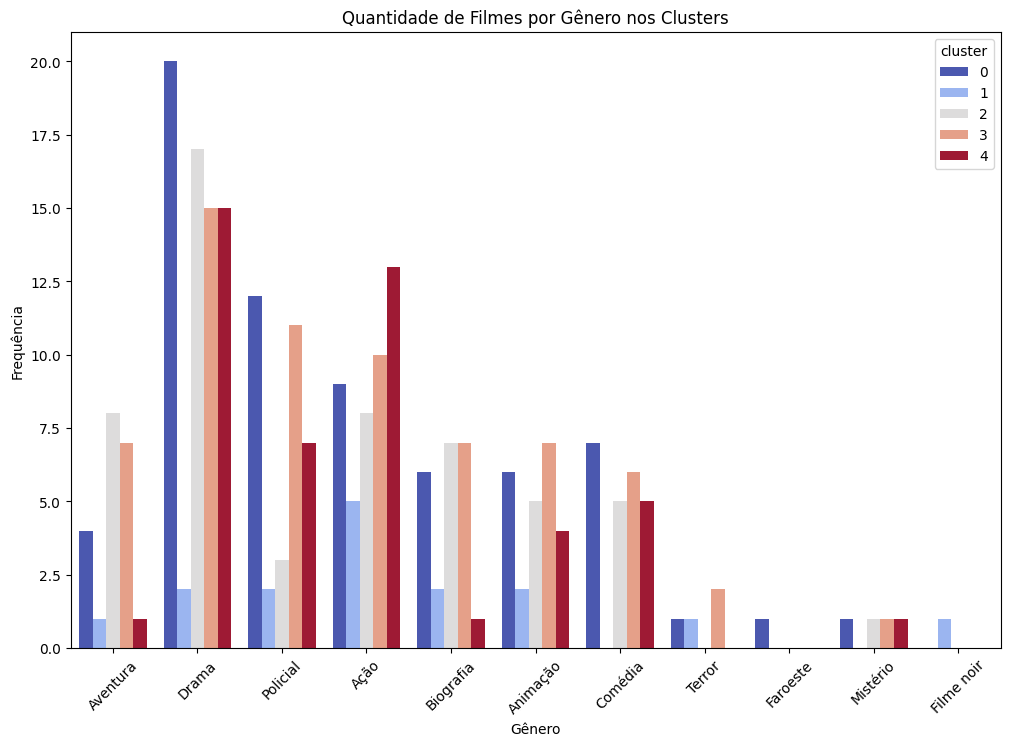

In [73]:
plt.figure(figsize=(12, 8))
sns.countplot(x='genre', hue='cluster', data=df, palette='coolwarm')
plt.title('Quantidade de Filmes por Gênero nos Clusters')
plt.xlabel('Gênero')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()

## Salvando o modelo, dataframe novo e embedding

In [75]:
# Salvar o modelo KMeans
dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']

In [76]:
# Salvando o Dataframe
# Buscando a coluna rating e ano originais
file_path = '/content/all_movies.csv'  # Substituir pelo caminho correto
df_original = pd.read_csv(file_path, delimiter=';')

# Adicionando colunas com os valores originais (antes da normalização)
df['rating_original'] = df_original['rating']
df['year_original'] = df_original['year']

# Salvar o DataFrame processado para usar no Streamlit
df.to_csv('all_movies_with_clusters.csv', index=False)


In [77]:
# Salvar os embeddings
np.save('bert_embeddings.npy', bert_embeddings)